# WORKFLOW 2

In [10]:
# IMPORTS
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# GLOBAL VARIABLES
execution_count = 1  # Adjust as needed
window_size = 100

dates = ["2025-02-03", "2025-02-04", "2025-02-05"]

folder_to_save = "./experiment_plots"

optimized_color = sns.color_palette("Blues", n_colors=1)[0]  # Main blue shade
baseline_color = sns.color_palette("Oranges", n_colors=1)[0]  # Main orange shade


theme_style = "darkgrid"
color_palette_style = "deep"

In [12]:
# PREPARE DATA

# prepare optimized data
df_list = []
for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-optimizedFunction-logs.csv'
    
    if os.path.exists(file_path):  # Check if file exists to avoid errors
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
        df['day'] = df['timestamp'].dt.date  # Extract date to a new column
        df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
        df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

        df_list.append(df)
# Concatenate all dataframes
df_all_days_optimized = pd.concat(df_list, ignore_index=True)


# prepare baseline data
df_list = []
for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-baselineFunction-logs.csv'
    
    if os.path.exists(file_path):  # Check if file exists to avoid errors
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
        df['day'] = df['timestamp'].dt.date  # Extract date to a new column
        df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
        df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

        df_list.append(df)
# Concatenate all dataframes
df_all_days_baseline = pd.concat(df_list, ignore_index=True)



# GROUP ALL DAYS TOGETHER
df_optimized_all_days = df_all_days_optimized
# Sort the dataframe by duration_minutes to ensure proper rolling calculations
df_optimized_all_days = df_optimized_all_days.sort_values(by='duration_minutes')

df_baseline_all_days = df_all_days_baseline
# Sort the dataframe by duration_minutes to ensure proper rolling calculations
df_baseline_all_days = df_baseline_all_days.sort_values(by='duration_minutes')


# Compute rolling median & std for optimized function
df_optimized_all_days['smoothed_median'] = df_optimized_all_days['execution_time'].rolling(window=window_size, center=True).median()
df_optimized_all_days['smoothed_std'] = df_optimized_all_days['execution_time'].rolling(window=window_size, center=True).std()

# Compute rolling median & std for baseline function
df_baseline_all_days['smoothed_median'] = df_baseline_all_days['execution_time'].rolling(window=window_size, center=True).median()
df_baseline_all_days['smoothed_std'] = df_baseline_all_days['execution_time'].rolling(window=window_size, center=True).std()

# Drop NaNs
df_optimized_all_days = df_optimized_all_days.dropna(subset=['smoothed_median', 'smoothed_std'])
df_baseline_all_days = df_baseline_all_days.dropna(subset=['smoothed_median', 'smoothed_std'])

##### SINGULAR EXECUTIONS

In [ ]:
# OPTIMIZED EXECUTIONS
sns.set_theme(style=theme_style)
num_days = df_all_days_optimized["day"].nunique()
palette = sns.color_palette("light:b", n_colors=num_days+2)[1:-1]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot execution time for different days
sns.lineplot(
    data=df_all_days_optimized, 
    x='duration_minutes', 
    y='smoothed_execution_time', 
    hue='day', 
    lw=2, 
    palette=palette
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Optimized Execution Time (ms)')
plt.title('Optimized Execution Time Over Multiple Days (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "execution-times-optimized.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show()

In [ ]:
# BASELINE EXECUTIONS
sns.set_theme(style=theme_style)
# palette = sns.color_palette("YlOrBr", n_colors=df_all_days_optimized["day"].nunique())
num_days = df_all_days_optimized["day"].nunique()
palette = sns.color_palette("light:r", n_colors=num_days+2)[1:-1]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot execution time for different days
sns.lineplot(
    data=df_all_days_optimized, 
    x='duration_minutes', 
    y='smoothed_execution_time', 
    hue='day', 
    lw=2, 
    palette=palette
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Baseline Execution Time (ms)')
plt.title('Baseline Execution Time Over Multiple Days (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "execution-times-baseline.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show()

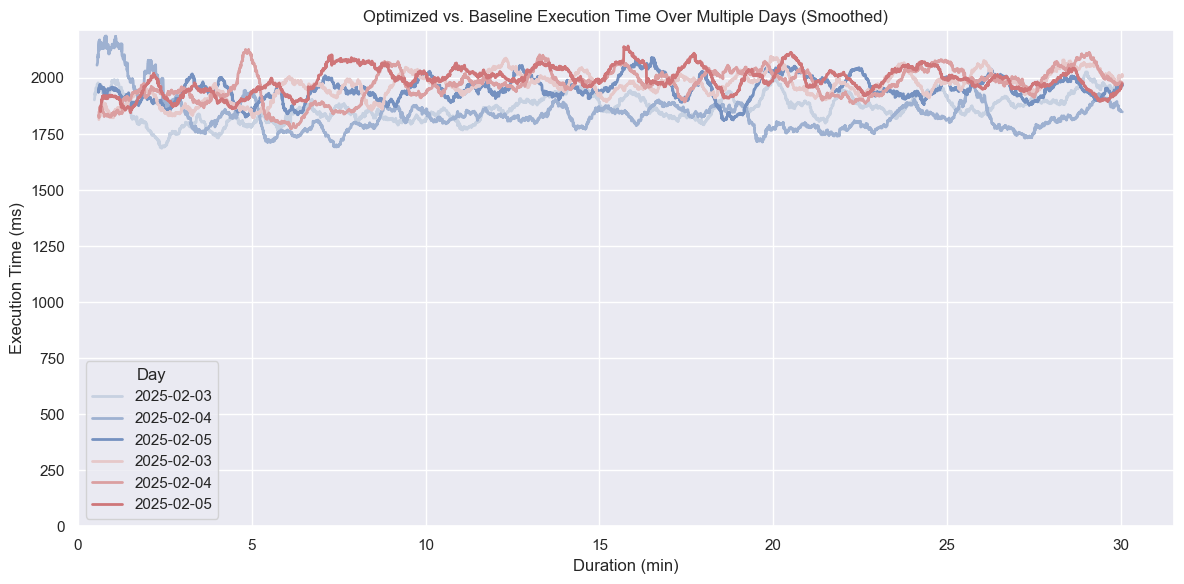

In [19]:
# BASELINE AND OPTIMIZED EXECUTIONS IN ONE GRAPH
sns.set_theme(style=theme_style)
num_days = df_all_days_optimized["day"].nunique()

# Define color palettes
optimized_palette = sns.color_palette("light:b", n_colors=num_days+2)[1:-1]
baseline_palette = sns.color_palette("light:r", n_colors=num_days+2)[1:-1]

plt.figure(figsize=(12, 6))

# Plot optimized execution times
optimized_lines = sns.lineplot(
    data=df_all_days_optimized,
    x='duration_minutes',
    y='smoothed_execution_time',
    hue='day',
    lw=2,
    palette=optimized_palette
)

# Plot baseline execution times
baseline_lines = sns.lineplot(
    data=df_all_days_baseline,
    x='duration_minutes',
    y='smoothed_execution_time',
    hue='day',
    lw=2,
    palette=baseline_palette
)

# Labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Optimized vs. Baseline Execution Time Over Multiple Days (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "execution-times-optimized-and-baseline.pdf")
plt.savefig(plot_filename)

# SHOW PLOT
plt.show()

##### GROUPED

In [ ]:
# OPTIMIZED RESULTS GROUPED WITH ERROR BAND

# Plot the data
sns.set_theme(style=theme_style)
palette = sns.color_palette(color_palette_style)

plt.figure(figsize=(12, 6))

# Plot smoothed median execution time
sns.lineplot(
    data=df_optimized_all_days,
    x='duration_minutes',
    y='smoothed_median',
    color=palette[0],
    label='Optimized Function (Smoothed Median)',
    lw=2
)

# Add error band using standard deviation
plt.fill_between(
    df_optimized_all_days['duration_minutes'],
    df_optimized_all_days['smoothed_median'] - df_optimized_all_days['smoothed_std'],
    df_optimized_all_days['smoothed_median'] + df_optimized_all_days['smoothed_std'],
    color=palette[0],
    alpha=0.2,
    label='Standard Deviation'
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Smoothed Median Execution Time with Error Band (Optimized Function)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "grouped-optimized-error-bands.pdf")
plt.savefig(plot_filename)

# Show plot
plt.show()

In [ ]:
# BASELINE RESULTS GROUPED WITH ERROR BAND

# Plot the data
sns.set_theme(style=theme_style)
palette = sns.color_palette(color_palette_style)

plt.figure(figsize=(12, 6))

# Plot smoothed median execution time
sns.lineplot(
    data=df_baseline_all_days,
    x='duration_minutes',
    y='smoothed_median',
    color=palette[1],
    label='Optimized Function (Smoothed Median)',
    lw=2
)

# Add error band using standard deviation
plt.fill_between(
    df_baseline_all_days['duration_minutes'],
    df_baseline_all_days['smoothed_median'] - df_baseline_all_days['smoothed_std'],
    df_baseline_all_days['smoothed_median'] + df_baseline_all_days['smoothed_std'],
    color=palette[1],
    alpha=0.2,
    label='Standard Deviation'
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Smoothed Median Execution Time with Error Band (Optimized Function)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "grouped-baseline-error-bands.pdf")
plt.savefig(plot_filename)

# Show plot
plt.show()

In [ ]:
# RESULTS GROUPED WITH ERROR BANDS

# Set up plot
sns.set_theme(style=theme_style)
palette = sns.color_palette(color_palette_style)

plt.figure(figsize=(12, 6))

# Optimized function
sns.lineplot(
    data=df_optimized_all_days, x='duration_minutes', y='smoothed_median',
    color=palette[0], label='Optimized Function (Smoothed Median)', lw=2
)
plt.fill_between(
    df_optimized_all_days['duration_minutes'],
    df_optimized_all_days['smoothed_median'] - df_optimized_all_days['smoothed_std'],
    df_optimized_all_days['smoothed_median'] + df_optimized_all_days['smoothed_std'],
    color=palette[0], alpha=0.2, label='Optimized Std Dev'
)

# Baseline function
sns.lineplot(
    data=df_baseline_all_days, x='duration_minutes', y='smoothed_median',
    color=palette[1], label='Baseline Function (Smoothed Median)', lw=2
)
plt.fill_between(
    df_baseline_all_days['duration_minutes'],
    df_baseline_all_days['smoothed_median'] - df_baseline_all_days['smoothed_std'],
    df_baseline_all_days['smoothed_median'] + df_baseline_all_days['smoothed_std'],
    color=palette[1], alpha=0.2, label='Baseline Std Dev'
)

# Labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time Comparison: Optimized vs. Baseline')

# Axis limits
plt.xlim(left=0)
plt.ylim(bottom=0)

# Legend
plt.legend()

# Layout adjustment
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "grouped-optimized-and-baseline-error-bands.pdf")
plt.savefig(plot_filename)

# Show plot
plt.show()